In [153]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns


from shapely import wkt
import geopandas as gpd

from matplotlib.lines import Line2D
from matplotlib_map_utils.core.north_arrow import north_arrow
from matplotlib_map_utils.core.scale_bar import scale_bar


from dotenv import load_dotenv
import os
load_dotenv()
DATA_PATH = os.getenv("DATA_PATH")
SAVE_PATH = os.getenv("RESULTS_PATH")
FULL_PAGE_WIDTH_CM = os.getenv("FULL_PAGE_WIDTH_CM")
FULL_PAGE_LENGTH_CM = os.getenv("FULL_PAGE_LENGTH_CM")

from src.loading_datasets import loading_brussels_shape
from src.plotting_utilities import setup_plotting, cm_to_inches

label_font, tick_font, title_font, legend_font = setup_plotting()

In [110]:
data = {
    'Years': [2012,2014,2016,2018,2019,2020,2021],
    '1-way bike lane':[82,88,83,104,105,89,91],
    'painted bike lane':[86,92,142,135,140,183,182],
    '2-way bike lane':[99,108,135,148,151,150,161],
    '2-way shared foot/cycle path':[1,0,5,9,10,41,71],
    '1-way shared foot/cycle path':[0,0,0,0,0,8,8],

}
data_pd = pd.DataFrame(data)

rename_map = {
    '1-way bike lane': 'Bike 1W',
    '2-way bike lane': 'Bike 2W',
    'painted bike lane': 'Painted',
    '1-way shared foot/cycle path': 'Shared 1W',
    '2-way shared foot/cycle path': 'Shared 2W',
}
data_pd = data_pd.rename(columns=rename_map)

# Logical order: bike lanes first, then shared
categories = ['Bike 1W', 'Bike 2W', 'Painted', 'Shared 1W', 'Shared 2W']

In [ ]:
from matplotlib_scalebar.scalebar import ScaleBar

bike_infrastructure_data = gpd.read_file(f"{DATA_PATH}/bike_infrastructure/planned_constucted_final_infrastructure.csv")

bike_infrastructure_data_with_locations = gpd.GeoDataFrame(
        data = bike_infrastructure_data,
        geometry= bike_infrastructure_data['geom'].apply(wkt.loads),crs = 'epsg:31370')


brussels_region_shape,brussels_municipalities_shape = loading_brussels_shape()

bike_infrastructure_data_with_locations["velo"] = (
    pd.to_numeric(
        bike_infrastructure_data_with_locations["velo"].replace(r"^\s*$", pd.NA, regex=True),
        errors="coerce"
    ).astype("Int64")
)

bike_infrastructure_data_with_locations["stavaza_magistrale"] = (
    pd.to_numeric(
        bike_infrastructure_data_with_locations["stavaza_magistrale"].replace(r"^\s*$", pd.NA, regex=True),
        errors="coerce"
    ).astype("Int64")
)

construction_status_mapping = {
    "10": "Completed",
    "5": "Under \n Construction",
    "0": "Planned"
}
construction_status_color_mapping = {
    "0": "#b41f1f",  # Red for Planned
    "5": "#ff7f0e",  # Orange for Under Construction
    "10": "#42b41f"   # Green for Done
}

infrastructure_types_mapping = {
    "p": "PLUS",
    "c": "COMFORT",
}

infrastructure_types_linestyle_mapping = {
    "p": "solid",  # Solid for PLUS
    "c": "dashed"    # Dashed for COMFORT
}



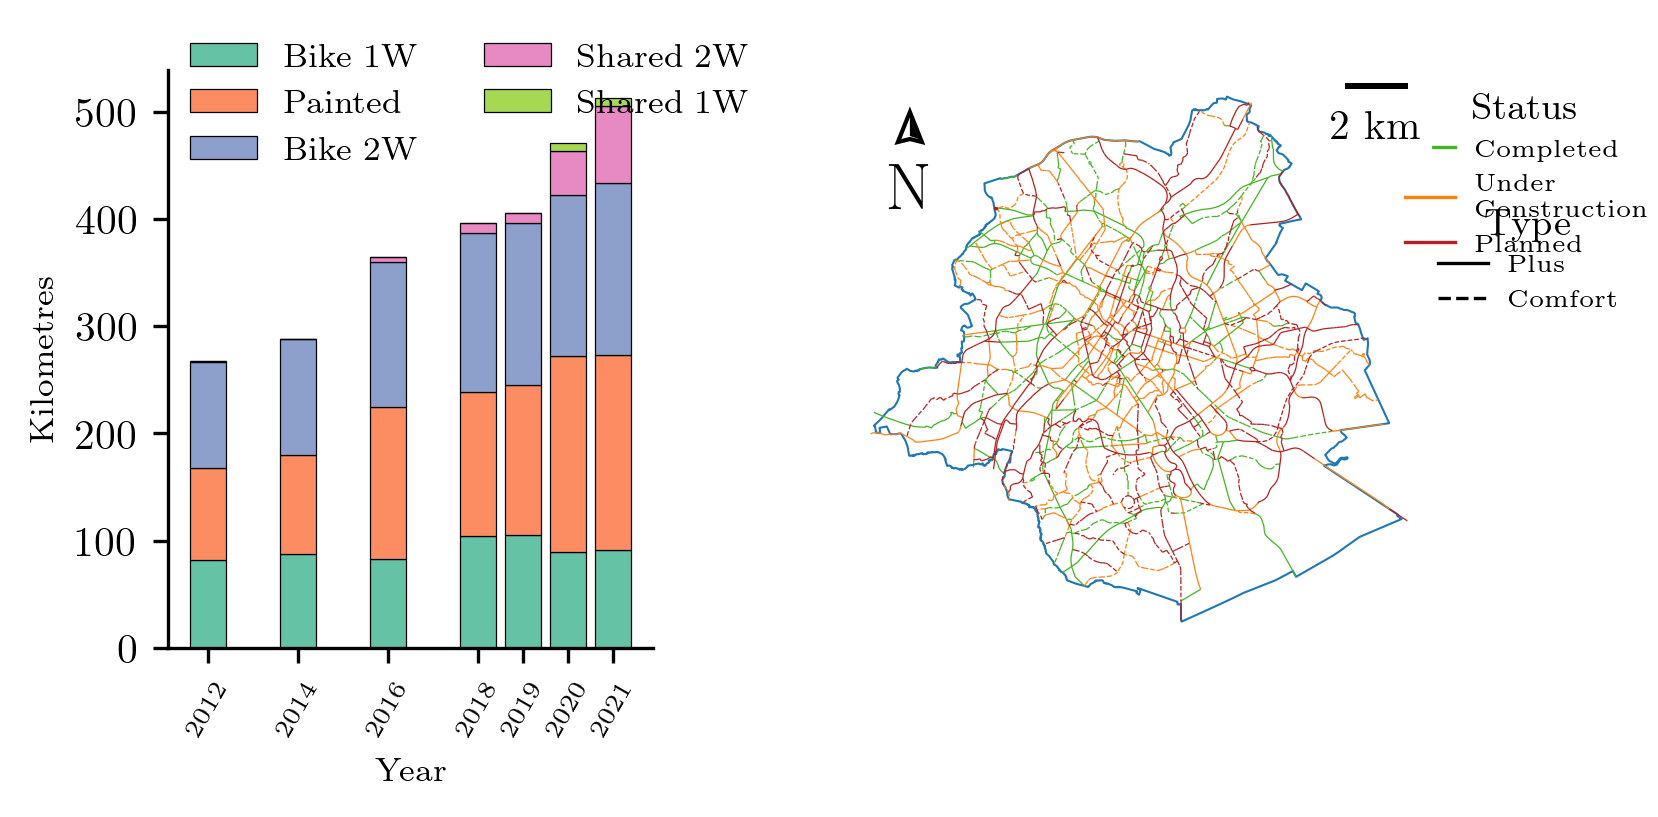

In [188]:
fig_total,ax_total = plt.subplots(1,2,figsize=(6.267,2.5),dpi = 300,gridspec_kw={'width_ratios':[1.5,3], 'wspace':0.0},constrained_layout=False)



#======== Plot 1: Stacked Bar Plot =======

# Stacked bar plot of data_pd using seaborn palette and matplotlib stacking

categories = [c for c in data_pd.columns if c != "Years"]
x = data_pd["Years"]
palette = sns.color_palette("Set2", n_colors=len(categories))

bottom = np.zeros(len(data_pd))
for color, col in zip(palette, categories):
    ax_total[0].bar(x, data_pd[col], bottom=bottom, color=color, label=col, edgecolor="black", linewidth=0.3)
    bottom += data_pd[col].values


ax_total[0].set_xlabel("Year", fontsize = label_font['fontsize'])
ax_total[0].set_ylabel("Kilometres", fontsize = label_font['fontsize'])
ax_total[0].set_xticks(x)
ax_total[0].set_xticklabels(x, rotation=60, **tick_font)
ax_total[0].legend(bbox_to_anchor=(-0.015, 1.1), loc="upper left", fontsize = legend_font["fontsize"],frameon=False,ncol=2)
sns.despine()


#========= Plot 2: Map Plot =======

ax_total[1].set_aspect('auto')
brussels_region_shape.boundary.plot(ax = ax_total[1],linewidth = 0.5, aspect='auto')

for status in construction_status_mapping.keys():
    for infra_type in infrastructure_types_mapping.keys():
        temp = bike_infrastructure_data_with_locations[bike_infrastructure_data_with_locations['stavaza_velo'] == str(status)+ str(infra_type)]

        if not temp.empty:
            temp.plot(
                ax = ax_total[1],
                linestyle = infrastructure_types_linestyle_mapping[infra_type],
                color = construction_status_color_mapping[status],
                linewidth=0.3,
                label = f"{infrastructure_types_mapping[infra_type]} - {construction_status_mapping[status]}", 
                aspect='auto'
            )


#cx.add_basemap(ax_2, crs = bike_infrastructure_data_with_locations.crs.to_string(), source=cx.providers.CartoDB.Positron)

# Legend for construction status (color)
status_handles = [
    Line2D([0], [0], color=construction_status_color_mapping[k], lw=0.8,
           linestyle='solid', label=construction_status_mapping[k])
    for k in construction_status_mapping.keys()
]

# Legend for infrastructure type (linestyle)
type_handles = [
    Line2D([0], [0], color='black', lw=0.8,
           linestyle=infrastructure_types_linestyle_mapping[k],
           label=infrastructure_types_mapping[k].capitalize())
    for k in infrastructure_types_mapping.keys()
]

leg_colors = ax_total[1].legend(handles=status_handles, title='Status', fontsize=6, title_fontsize=9,
                         loc='upper right', frameon=False, bbox_to_anchor=(1.40, 1.0))
leg_styles = ax_total[1].legend(handles=type_handles, title='Type', fontsize=6, title_fontsize=9,
                         loc='upper right', frameon=False, bbox_to_anchor=(1.35, 0.8))
ax_total[1].add_artist(leg_colors)


ax_total[1].set_axis_off()

ax_total[1].add_artist(ScaleBar(1))

north_arrow(
    ax_total[1], location="upper left", rotation={"crs": brussels_region_shape.crs, "reference": "center"},
    scale=0.1,shadow=False)


fig_total.savefig(f"{SAVE_PATH}/figures/main/figure_3.pdf", dpi=300)
# Further layout adjustments are done in Illustrator

# Alternative Figure 3

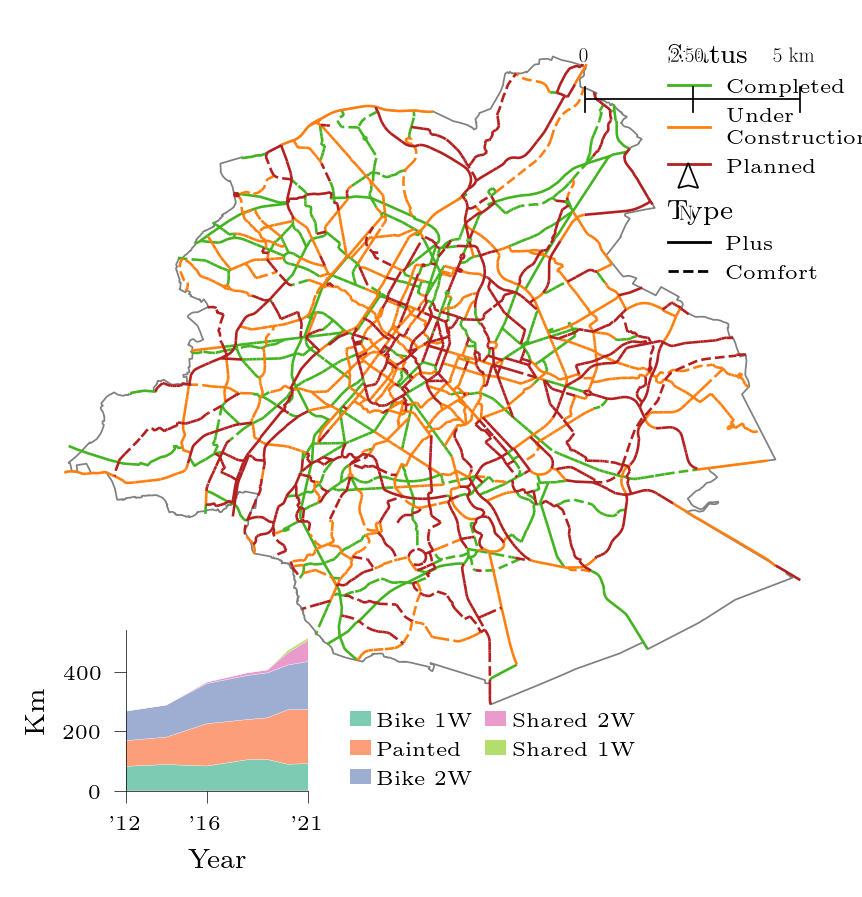

In [191]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create single figure with map as main axes
fig, ax_map = plt.subplots(figsize=(cm_to_inches(float(FULL_PAGE_WIDTH_CM)/1.5), cm_to_inches(float(FULL_PAGE_WIDTH_CM)/1.5)),dpi = 250)

# ========= Main Plot: Map =======
aspect = 0.9
brussels_region_shape.boundary.plot(ax=ax_map, linewidth=0.5, aspect=aspect, color='grey')

for status in construction_status_mapping.keys():
    for infra_type in infrastructure_types_mapping.keys():
        temp = bike_infrastructure_data_with_locations[
            bike_infrastructure_data_with_locations['stavaza_velo'] == str(status) + str(infra_type)
        ]
        if not temp.empty:
            temp.plot(
                ax=ax_map,
                linestyle=infrastructure_types_linestyle_mapping[infra_type],
                color=construction_status_color_mapping[status],
                linewidth=0.75,
                label=f"{infrastructure_types_mapping[infra_type]} - {construction_status_mapping[status]}",
                aspect=aspect
            )

# Map legends
status_handles = [
    Line2D([0], [0], color=construction_status_color_mapping[k], lw=0.8,
           linestyle='solid', label=construction_status_mapping[k])
    for k in construction_status_mapping.keys()
]
type_handles = [
    Line2D([0], [0], color='black', lw=0.8,
           linestyle=infrastructure_types_linestyle_mapping[k],
           label=infrastructure_types_mapping[k].capitalize())
    for k in infrastructure_types_mapping.keys()
]

leg_colors = ax_map.legend(handles=status_handles, title='Status', fontsize=6, title_fontsize=8,
                           loc='upper right', frameon=False, bbox_to_anchor=(1.065, 1),
                           alignment='left')
ax_map.add_artist(leg_colors)

leg_styles = ax_map.legend(handles=type_handles, title='Type', fontsize=6, title_fontsize=8,
                           loc='upper right', frameon=False, bbox_to_anchor=(1, 0.78),  # adjust this value
                           alignment='left')

ax_map.set_axis_off()

scale_bar(ax_map, location="upper right", style="ticks",
    bar={"projection": brussels_region_shape.crs, "max": 5, "major_div": 2,
         "minor_div": 1, "tick_loc": "middle", "tickwidth": 0.5},
    labels={"loc": "above", "style": "major", "fontsize": 6},
    units={"loc": "text", "fontsize": 6},aob={"pad": 0.1,'bbox_transform':ax_map.transAxes})

north_arrow(ax_map, location="upper right", rotation={"crs": brussels_region_shape.crs, "reference": "center"},
    scale=0.1, shadow=False, fancy=False, base={"linewidth": 0.5}, label={"fontsize": 6},aob={"pad": 3.5})

# ======== Inset: Stacked Bar Plot =======
# Position: [x0, y0, width, height] in axes fraction coordinates
ax_inset = inset_axes(ax_map, width="25%", height="25%", loc='lower left',
                      bbox_to_anchor=(0.1, -.1, 0.9, 0.9), bbox_transform=ax_map.transAxes)

categories = [c for c in data_pd.columns if c != "Years"]
x = data_pd["Years"]
palette = sns.color_palette("Set2", n_colors=len(categories))

# Stack the data: each row is a category's values across years
y_stack = [data_pd[col].values for col in categories]

ax_inset.stackplot(x, *y_stack, labels=categories, colors=palette, alpha=0.85)

# Optional: add lines on top of each layer for definition
bottom = np.zeros(len(data_pd))
for color, col in zip(palette, categories):
    bottom += data_pd[col].values
    ax_inset.plot(x, bottom, color='white', linewidth=0.1)      

ax_inset.set_xlabel("Year", fontsize=label_font['fontsize'])
ax_inset.set_ylabel("Km", fontsize=label_font['fontsize'])
tick_years = [2012, 2016, 2021]
ax_inset.set_xticks(tick_years)
ax_inset.set_xticklabels([f"'{y % 100:02d}" for y in tick_years])
ax_inset.set_xlim(x.min(), x.max())  # remove padding on x-axis
ax_inset.tick_params(axis='both', which='both', width=0.2, labelsize=tick_font['fontsize'])   
ax_inset.legend(
    fontsize=6, ncol=2, loc='lower right',
    handlelength=1, handletextpad=0.3, columnspacing=0.6,
    frameon=False,bbox_to_anchor=(2.9,-0.1)
)


ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)
ax_inset.spines['bottom'].set_linewidth(0.2)
ax_inset.spines['left'].set_linewidth(0.2)